In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"
known_loci_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/datasrc/cteph_reported_loci.xlsx" 

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)
known_loci = pd.read_excel(known_loci_path)

In [2]:
model = "additive"

In [3]:
import pandas as pd

results_dict = {}

for key in case_pqtl.keys():

    case_ids = case_pqtl[key][case_pqtl[key][f'{model}_pvalue'] < 0.05]['SeqId']
    control_ids = control_pqtl[key][control_pqtl[key][f'{model}_pvalue'] < 0.05]['SeqId']
    # unique_ids = pd.concat([case_ids, control_ids]).drop_duplicates().tolist()
    unique_ids = case_ids[case_ids.isin(control_ids)].tolist()

    results = []
    for seq_id in unique_ids:
        if seq_id in case_pqtl[key]['SeqId'].values:
            case_row = case_pqtl[key][case_pqtl[key]['SeqId'] == seq_id]
            case_beta = case_row[f'{model}_beta'].iloc[0]
            case_pvalue = case_row[f'{model}_pvalue'].iloc[0]
            case_sd = case_row[f'{model}_sd'].iloc[0]
        else:
            case_beta = None
            case_pvalue = None

        if seq_id in control_pqtl[key]['SeqId'].values:
            control_row = control_pqtl[key][control_pqtl[key]['SeqId'] == seq_id]
            control_beta = control_row[f'{model}_beta'].iloc[0]
            control_pvalue = control_row[f'{model}_pvalue'].iloc[0]
            control_sd = control_row[f'{model}_sd'].iloc[0]
        else:
            control_beta = None
            control_pvalue = None

        results.append({
            'SeqId': seq_id,
            'case_beta': case_beta,
            'case_pvalue': case_pvalue,
            'case_sd': case_sd,
            'control_beta': control_beta,
            'control_pvalue': control_pvalue, 
            'control_sd': control_sd
        })

    results_dict[key] = pd.DataFrame(results)


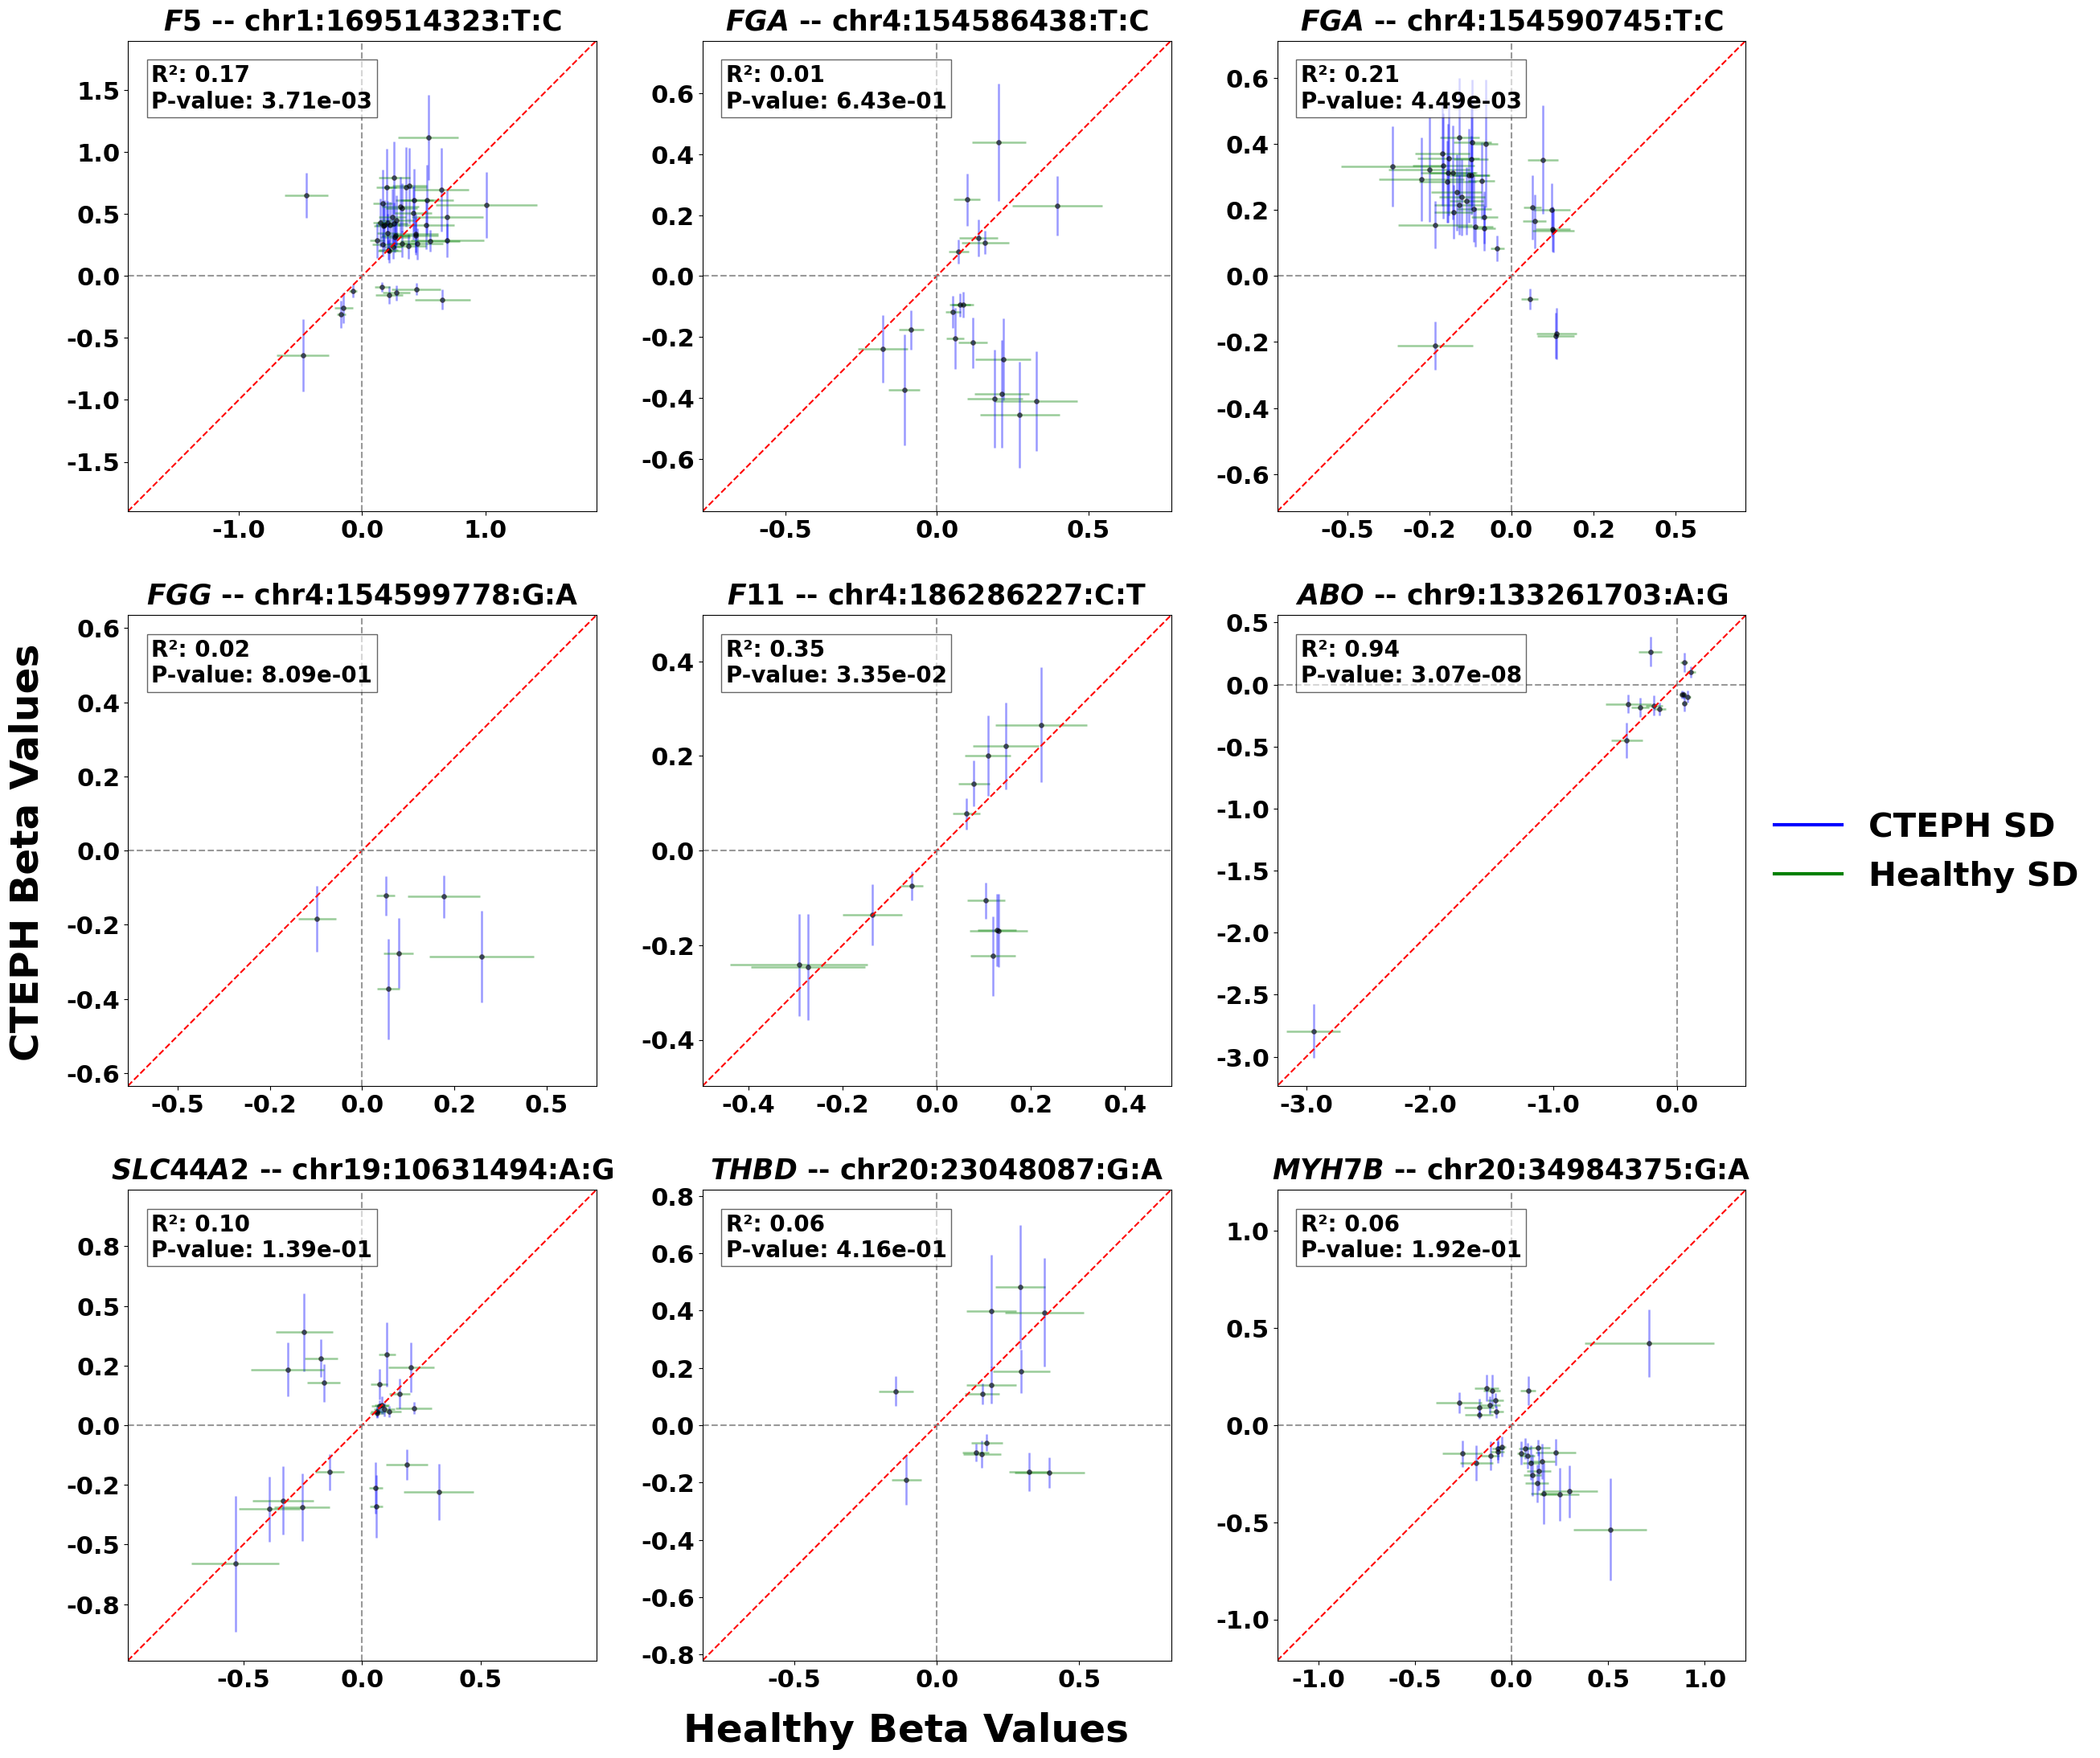

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.stats import linregress
from matplotlib.lines import Line2D

plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

keys = list(case_pqtl.keys())
fig, axes = plt.subplots(3, 3, figsize=(22, 22)) 
axes = axes.flatten() # flatten the 2D array of axes to 1D

# define a function to format the tick labels
def format_func(value, tick_number):
    return f'{value:.1f}'

# iterate over the results_dict and plot the data
for index, (key, df) in enumerate(results_dict.items()):
    
    ax = axes[index]
    control_betas = []
    case_betas = []
    
    for _, row in df.iterrows():
        color = 'black' if row['case_pvalue'] < 0.05 and row['control_pvalue'] < 0.05 else 'gray'
        ax.scatter(row['control_beta'], row['case_beta'], color=color, marker='o', s=15, alpha=0.5, label='Data Points' if index == 0 else "")
        control_betas.append(row['control_beta'])
        case_betas.append(row['case_beta'])
        
        # Extract case_sd and control_sd
        case_sd = row['case_sd']
        control_sd = row['control_sd']
        
        # Add error bars (crosses)
        ax.errorbar(row['control_beta'], row['case_beta'], xerr=control_sd, fmt='none', ecolor='green', capsize=0, elinewidth=1.8, zorder=0, alpha=0.4, label='Control SD' if index == 0 else "")
        ax.errorbar(row['control_beta'], row['case_beta'], yerr=case_sd, fmt='none', ecolor='blue', capsize=0, elinewidth=1.8, zorder=0, alpha=0.4, label='Case SD' if index == 0 else "")

    # calculate the linear regression
    control_betas = np.array(control_betas)
    case_betas = np.array(case_betas)
    slope, intercept, r_value, p_value, std_err = linregress(control_betas, case_betas)
    r_squared = r_value**2

    # Calculate the buffer for the plot
    buffer = 0.7  # buffer around the data
    max_range = max(abs(min(control_betas)), abs(max(control_betas)), abs(min(case_betas)), abs(max(case_betas)))  
    range_extension = max_range * buffer

    # Set the limits of the plot, with the buffer
    min_beta_extended = -max_range - range_extension
    max_beta_extended = max_range + range_extension

    # Adjust axis limits for specific subplot
    if key == 'chr9:133261703:A:G':  # Apply special axis limit adjustments
        data_min = min(min(control_betas), min(case_betas))
        data_max = max(max(control_betas), max(case_betas))
        buffer = 0.1 * max(abs(data_min), abs(data_max))  # Smaller buffer for better data representation
        ax.set_xlim(data_min - buffer, data_max + buffer)
        ax.set_ylim(data_min - buffer, data_max + buffer)
    else:
        ax.set_xlim(min_beta_extended, max_beta_extended)
        ax.set_ylim(min_beta_extended, max_beta_extended)

    # y=x line
    ax.plot([min_beta_extended, max_beta_extended], [min_beta_extended, max_beta_extended], 'r--', label='y=x' if index == 0 else "")

    # add a horizontal and vertical line at 0
    ax.axhline(0, color='gray', linestyle='--', alpha=0.8)  # Horizontal line at y=0
    ax.axvline(0, color='gray', linestyle='--', alpha=0.8)  # Vertical line at x=0

    # add a title to the subplot
    gene = known_loci.loc[known_loci['ID'] == key, 'GENE'].values[0]
    ax.set_title(f'$\\it{{{gene}}}$ {"-"*2} {key}', fontsize=25, transform=ax.transAxes, verticalalignment='top', weight='bold', y=1.07)
    ax.tick_params(axis='both', labelsize=22)

    # add the linear regression equation to the plot
    ax.text(0.05, 0.95, f'R²: {r_squared:.2f}\nP-value: {p_value:.2e}', transform=ax.transAxes, verticalalignment='top', fontsize=20, color='black', bbox=dict(facecolor='white', alpha=0.6))

    # format the tick labels
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# add global X and Y labels more appropriately and adjust their position
fig.text(0.5, 0.003, 'Healthy Beta Values', ha='center', va='center', fontsize=35, weight='bold')  # X-axis label
fig.text(0.003, 0.5, 'CTEPH Beta Values', ha='center', va='center', rotation='vertical', fontsize=35, weight='bold')  # Y-axis label

# Create custom legend handles
legend_elements = [Line2D([0], [0], color='blue', lw=3, label='CTEPH SD'), 
                   Line2D([0], [0], color='green', lw=3, label='Healthy SD')]

fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.18, 0.5), frameon=False, fontsize=30, markerscale=2)

plt.tight_layout(pad=4.0)  # Increase padding between subplots
plt.show()